In [2]:
import numpy as np

arr = np.zeros((10, 224, 224, 4))
for i in range(10):
    for j in range(4):
        arr[i, :, :, j] += i*10+j

print(arr[0, 0, 0, 2], arr[0, 0, 0, 3])
print(arr[1, 0, 0, 2], arr[1, 0, 0, 3])
print(arr.shape)

2.0 3.0
12.0 13.0
(10, 224, 224, 4)


In [3]:
carr = arr.transpose((1, 2, 0, 3)).reshape((224, 224, -1))

print(carr[0, 0, 2], carr[0, 0, 3])
print(carr[0, 0, 1*4+2], carr[0, 0, 1*4+3])
print(carr.shape)

2.0 3.0
12.0 13.0
(224, 224, 40)


# hugging face custom dataset import

In [3]:
from datasets import load_dataset
data = load_dataset("../data/20230419_224x224/20230419_224x224.py", "noisy", \
    cache_dir="/pscratch/sd/s/shubh/")

KeyboardInterrupt: 

In [4]:
from datasets import load_dataset
data_noiseless = load_dataset("../data/20230419_224x224/20230419_224x224.py", "noiseless", \
    cache_dir="/pscratch/sd/s/shubh/")

In [4]:
# id2label = {id:label for id, label in enumerate(data["train"].features) if label != "map"}
id2label = {id:label for id, label in enumerate(["Om", "s8"])}
label2id = {label:id for id,label in id2label.items()}
id2label, label2id

({0: 'Om', 1: 's8'}, {'Om': 0, 's8': 1})

# ViT

In [16]:
from transformers import AutoImageProcessor, ViTForImageClassification, ViTConfig, ViTModel

checkpoint = "google/vit-base-patch16-224-in21k"
model = ViTForImageClassification.from_pretrained(checkpoint, # num_labels=2, \
            problem_type = "regression", id2label=id2label, label2id=label2id,
            num_channels=1, image_size=224, patch_size=16, ignore_mismatched_sizes=True)

print(model.config.problem_type)
print(model.config.num_labels)

model

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClass

regression
2


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [17]:
model.config

ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "Omega_m",
    "1": "sigma_8"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Omega_m": 0,
    "sigma_8": 1
  },
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 1,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "problem_type": "regression",
  "qkv_bias": true,
  "transformers_version": "4.28.1"
}

In [18]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
import numpy as np 
from matplotlib import pyplot as plt
from PIL import Image

size = (model.config.image_size, model.config.image_size)

print(size)

# train_data_augmentation = keras.Sequential(
#     [
#         layers.Resizing(size[0], size[1]),
#         layers.Normalization(),
#         layers.RandomFlip("horizontal"),
#         layers.RandomFlip("vertical"),
#     ],
#     name="train_data_augmentation",
# )

# val_data_augmentation = keras.Sequential(
#     [
#         layers.Resizing(size[0], size[1]),
#         layers.Normalization(),
#     ],
#     name="val_data_augmentation",
# )

from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomVerticalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)

normalize = Normalize(mean=0, std=1)

train_data_augmentation = Compose(
        [
            Resize(size),
            RandomHorizontalFlip(),
            RandomVerticalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_data_augmentation = Compose(
        [
            Resize(size),
            ToTensor(),
            normalize,
        ]
    )

(224, 224)


In [19]:
# def convert_to_tf_tensor(image: Image):
#     return tf.expand_dims(tf.convert_to_tensor(np.asarray(image)), axis=-1)


# def preprocess_train(example_batch):
#     """Apply train_transforms across a batch."""
#     images = [
#         train_data_augmentation(convert_to_tf_tensor(image)) for image in example_batch["map"]
#     ]
#     example_batch["labels"] = tf.transpose([example_batch[x] for x in example_batch.keys() if x != "map"])
#     example_batch["pixel_values"] = [tf.transpose(tf.squeeze(image)) for image in images]
#     return example_batch


# def preprocess_val(example_batch):
#     """Apply val_transforms across a batch."""
#     images = [
#         val_data_augmentation(convert_to_tf_tensor(image)) for image in example_batch["map"]
#     ]
#     example_batch["labels"] = tf.transpose([example_batch[x] for x in example_batch.keys() if x != "map"])
#     example_batch["pixel_values"] = [tf.transpose(tf.squeeze(image)) for image in images]
#     return example_batch

def preprocess_train(examples):
    # examples["labels"] = np.transpose([examples[x] for x in examples.keys() if x != "map"]).astype(np.float32)
    examples["labels"] = np.transpose([examples[x] for x in ["Omega_m", "sigma_8"]]).astype(np.float32)
    examples['pixel_values'] = [train_data_augmentation(image) for image in examples['map']]
    return examples

def preprocess_val(examples):
    # examples["labels"] = np.transpose([examples[x] for x in examples.keys() if x != "map"]).astype(np.float32)
    examples["labels"] = np.transpose([examples[x] for x in ["Omega_m", "sigma_8"]]).astype(np.float32)
    examples['pixel_values'] = [val_data_augmentation(image) for image in examples['map']]
    return examples

data["train"].set_transform(preprocess_train)
data["validation"].set_transform(preprocess_val)
data["test"].set_transform(preprocess_val)

In [20]:
data["train"][0:3]

{'Omega_m': [0.10410156100988388, 0.39335936307907104, 0.20000000298023224],
 'H_0': [79.9873046875, 79.732421875, 77.5],
 'n_s': [0.9730273485183716, 1.0655077695846558, 0.9200000166893005],
 'sigma_8': [0.9395507574081421, 0.7017577886581421, 1.149999976158142],
 'w_0': [-0.36800047755241394, -0.520211935043335, -0.749750018119812],
 'map': [<PIL.TiffImagePlugin.TiffImageFile image mode=F size=66x66>,
  <PIL.TiffImagePlugin.TiffImageFile image mode=F size=66x66>,
  <PIL.TiffImagePlugin.TiffImageFile image mode=F size=66x66>],
 'labels': array([[0.10410156, 0.93955076],
        [0.39335936, 0.7017578 ],
        [0.2       , 1.15      ]], dtype=float32),
 'pixel_values': [tensor([[[ 0.0013,  0.0013,  0.0003,  ..., -0.0050, -0.0051, -0.0051],
           [ 0.0013,  0.0013,  0.0003,  ..., -0.0050, -0.0051, -0.0051],
           [ 0.0004,  0.0004, -0.0003,  ..., -0.0049, -0.0049, -0.0049],
           ...,
           [-0.0022, -0.0022, -0.0021,  ..., -0.0049, -0.0049, -0.0049],
           [-

In [21]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["labels"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(data["train"], collate_fn=collate_fn, batch_size=4)

In [22]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
    if isinstance(v, torch.Tensor):
        print(k, v.shape)

pixel_values torch.Size([4, 1, 224, 224])
labels torch.Size([4, 2])


In [ ]:
plt.imshow(data["train"][0]["pixel_values"][0], origin="lower")
plt.show()
plt.close()

In [ ]:
plt.imshow(np.asarray(data["train"][0]["map"]), origin="lower")
plt.show()
plt.close()

In [12]:
from transformers import create_optimizer

batch_size = 32
num_epochs = 5
num_train_steps = len(data["train"]) * num_epochs
learning_rate = 0.001
weight_decay_rate = 0.0001

optimizer, lr_schedule = create_optimizer(
    init_lr=learning_rate,
    num_train_steps=num_train_steps,
    weight_decay_rate=weight_decay_rate,
    num_warmup_steps=0,
)

2023-05-17 07:52:46.973005: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-17 07:52:49.440760: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [13]:
# from transformers import DefaultDataCollator
# data_collator = DefaultDataCollator(return_tensors="tf")

# # converting our train dataset to tf.data.Dataset
# tf_train_dataset = data["train"].to_tf_dataset(
#     columns=["pixel_values", "Omega_m", "H_0", "n_s", "sigma_8", "w_0"], shuffle=True, batch_size=batch_size, collate_fn=data_collator
# )

# # converting our test dataset to tf.data.Dataset
# tf_eval_dataset = data["test"].to_tf_dataset(
#     columns=["pixel_values", "Omega_m", "H_0", "n_s", "sigma_8", "w_0"], shuffle=True, batch_size=batch_size, collate_fn=data_collator
# )

In [14]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    f"test",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    num_train_epochs=5,
    weight_decay=0.0001,
    load_best_model_at_end=True,
    logging_dir='logs',
    remove_unused_columns=False,
)

In [15]:
import torch

trainer = Trainer(
    model,
    args,
    train_dataset= data["train"],
    eval_dataset= data["validation"],
    data_collator=collate_fn
)

In [44]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.004100,0.004333
2,0.004200,0.004333
3,0.004200,0.004333
4,0.004300,0.004333


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

In [45]:
from pathlib import Path

# out_dir = "../models/20230905_vit/"
out_dir = "../models/20230905_vit_2var_more/"
Path(out_dir).mkdir(parents=True, exist_ok=True)

trainer.save_model(out_dir)

In [48]:
preds = trainer.predict(data["validation"])
preds

PredictionOutput(predictions=array([[0.29177195, 0.4910082 ],
       [0.26145342, 1.1797332 ],
       [0.42495924, 0.7854945 ],
       ...,
       [0.26666746, 1.1040564 ],
       [0.18599786, 0.7490439 ],
       [0.4401842 , 0.5383577 ]], dtype=float32), label_ids=array([[0.29335937, 0.45175782],
       [0.22929688, 1.252539  ],
       [0.4260742 , 0.7781738 ],
       ...,
       [0.253125  , 1.1890625 ],
       [0.1595703 , 0.8008789 ],
       [0.47148436, 0.5064453 ]], dtype=float32), metrics={'test_loss': 0.0043327538296580315, 'test_runtime': 36.6524, 'test_samples_per_second': 272.833, 'test_steps_per_second': 34.104})

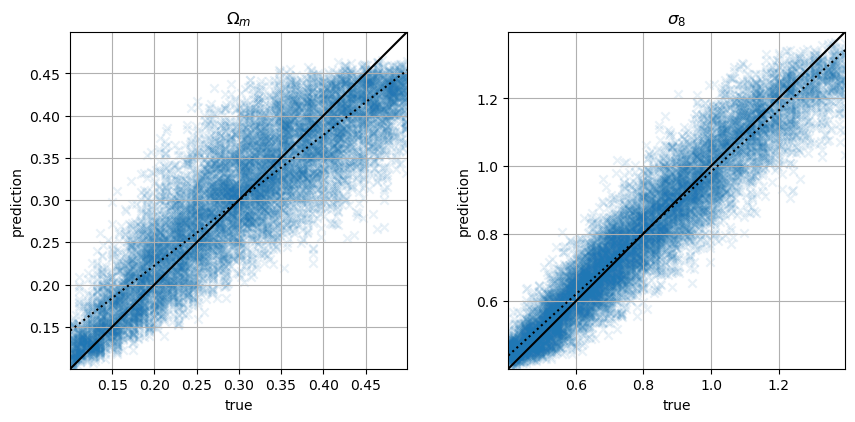

In [49]:
plot_y, predictions = preds.label_ids, preds.predictions

upp_lims = np.nanmax(plot_y, axis=0)
low_lims = np.nanmin(plot_y, axis=0)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.subplots_adjust(wspace=0.3, hspace=0.2)
labels = [r"$\Omega_m$", r"$\sigma_8$"]
for ind, (label, ax, low_lim, upp_lim) in enumerate(zip(labels, axs.ravel(), low_lims, upp_lims)):
    p = np.poly1d(np.polyfit(plot_y[:, ind], predictions[:, ind], 1))
    ax.scatter(plot_y[:, ind], predictions[:, ind], marker="x", alpha=0.1)
    ax.set_xlabel("true")
    ax.set_ylabel("prediction")
    ax.plot([low_lim, upp_lim], [low_lim, upp_lim], color="black")
    ax.plot([low_lim, upp_lim], [p(low_lim), p(upp_lim)], color="black", ls=":")
    ax.set_xlim([low_lim, upp_lim])
    ax.set_ylim([low_lim, upp_lim])
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(label)
    ax.grid()
plt.show()
plt.close()

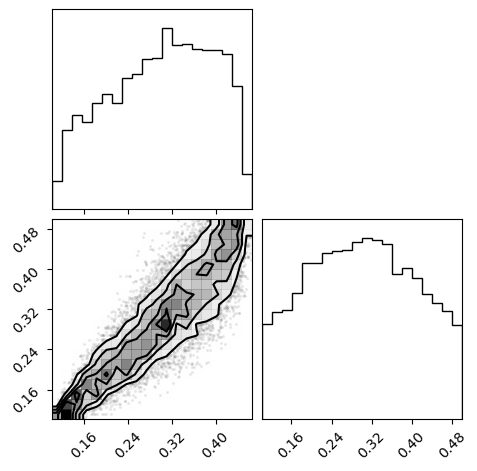

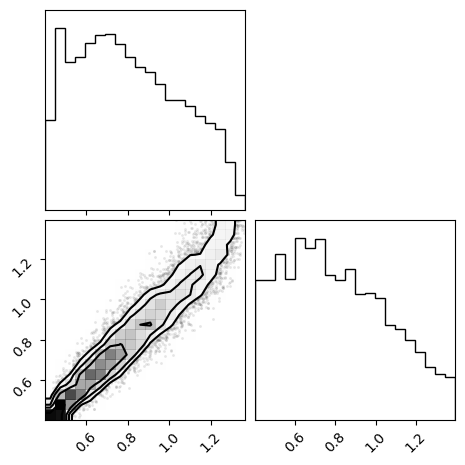

In [60]:
import corner

for ind in [0, 1]:
    corner.corner(np.vstack((predictions[:, ind], plot_y[:, ind])).T)

In [ ]:
np.savez("vit", plot_y=plot_y, predictions=predictions)

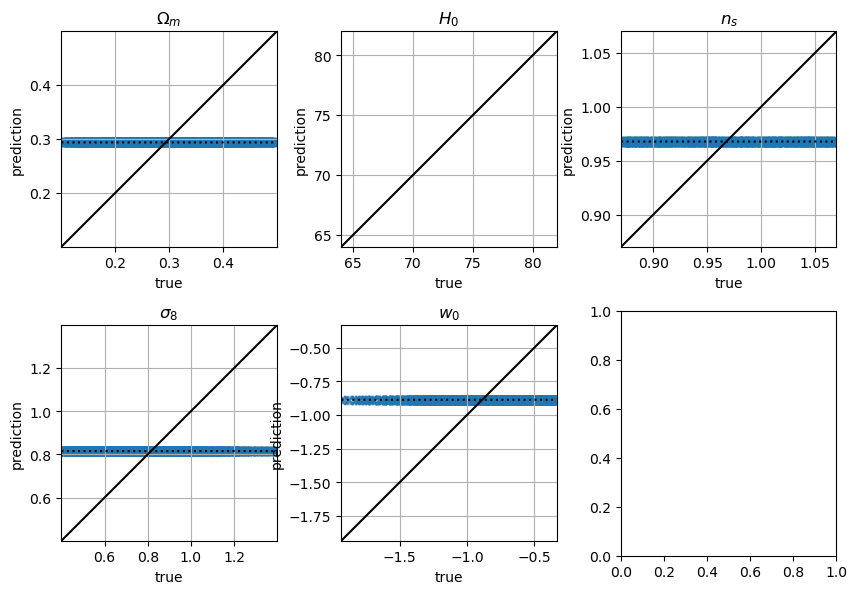

In [144]:
plot_y, predictions = preds.label_ids, preds.predictions

upp_lims = np.nanmax(plot_y, axis=0)
low_lims = np.nanmin(plot_y, axis=0)
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 7))
fig.subplots_adjust(wspace=0.3, hspace=0.2)
labels = [r"$\Omega_m$", r"$H_0$", r"$n_s$", r"$\sigma_8$", r"$w_0$", r"$$"]
for ind, (label, ax, low_lim, upp_lim) in enumerate(zip(labels, axs.ravel(), low_lims, upp_lims)):
    p = np.poly1d(np.polyfit(plot_y[:, ind], predictions[:, ind], 1))
    ax.scatter(plot_y[:, ind], predictions[:, ind], marker="x", alpha=0.1)
    ax.set_xlabel("true")
    ax.set_ylabel("prediction")
    ax.plot([low_lim, upp_lim], [low_lim, upp_lim], color="black")
    ax.plot([low_lim, upp_lim], [p(low_lim), p(upp_lim)], color="black", ls=":")
    ax.set_xlim([low_lim, upp_lim])
    ax.set_ylim([low_lim, upp_lim])
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(label)
    ax.grid()
plt.show()
plt.close()

# ViT with dropout

In [5]:
from transformers import AutoImageProcessor, ViTForImageClassification, ViTConfig, ViTModel

checkpoint = "google/vit-base-patch16-224-in21k"
model = ViTForImageClassification.from_pretrained(checkpoint, # num_labels=2, \
            problem_type = "regression", id2label=id2label, label2id=label2id, hidden_dropout_prob=0.1,
            num_channels=40, image_size=224, patch_size=16, ignore_mismatched_sizes=True)

print(model.config.problem_type)
print(model.config.num_labels)

model

2023-06-27 13:32:15.214087: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-27 13:32:26.985804: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identica

regression
2


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(40, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=

In [6]:
model.config

ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Om",
    "1": "s8"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Om": 0,
    "s8": 1
  },
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 40,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "problem_type": "regression",
  "qkv_bias": true,
  "transformers_version": "4.30.2"
}

In [7]:
import numpy as np 
from matplotlib import pyplot as plt
from PIL import Image
import torch

size = (224, 224)

print(size)

from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomVerticalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)

normalize = Normalize(mean=0, std=1)

train_data_augmentation = Compose(
        [
            RandomHorizontalFlip(),
            RandomVerticalFlip(),
            normalize,
        ]
    )

val_data_augmentation = Compose(
        [
            normalize,
        ]
    )

def preprocess_train(examples):
    # examples["labels"] = np.transpose([examples[x] for x in examples.keys() if x != "map"]).astype(np.float32)
    examples["labels"] = np.transpose([examples[x] for x in ["Om", "s8"]]).astype(np.float32)
    examples['pixel_values'] = [train_data_augmentation(torch.swapaxes(torch.Tensor(np.array(image)), 0, 2)) for image in examples['map']]
    return examples

def preprocess_val(examples):
    # examples["labels"] = np.transpose([examples[x] for x in examples.keys() if x != "map"]).astype(np.float32)
    examples["labels"] = np.transpose([examples[x] for x in ["Om", "s8"]]).astype(np.float32)
    examples['pixel_values'] = [val_data_augmentation(torch.swapaxes(torch.Tensor(np.array(image)), 0, 2)) for image in examples['map']]
    return examples

data["train"].set_transform(preprocess_train)
data["validation"].set_transform(preprocess_val)
data["test"].set_transform(preprocess_val)

(224, 224)


In [8]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["labels"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(data["train"], collate_fn=collate_fn, batch_size=4)

In [9]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
    if isinstance(v, torch.Tensor):
        print(k, v.shape)

pixel_values torch.Size([4, 40, 224, 224])
labels torch.Size([4, 2])


/tmp/ipykernel_379170/3338418760.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  labels = torch.tensor([example["labels"] for example in examples])


In [10]:
from transformers import create_optimizer

batch_size = 32
num_epochs = 2
num_train_steps = len(data["train"]) * num_epochs
learning_rate = 0.001
weight_decay_rate = 0.001

optimizer, lr_schedule = create_optimizer(
    init_lr=learning_rate,
    num_train_steps=num_train_steps,
    weight_decay_rate=weight_decay_rate,
    num_warmup_steps=0,
)

In [11]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    f"dropout",
    save_strategy="epoch",
    evaluation_strategy="epoch",
    num_train_epochs=2,
    weight_decay=0.001,
    load_best_model_at_end=True,
    logging_dir='logs',
    remove_unused_columns=False,
)

In [12]:
import sys
sys.path.append("../scripts/")
from TrainerWithDropout import DropoutTrainer

In [13]:
import torch

trainer = DropoutTrainer(
    model,
    args,
    train_dataset= data["train"],
    eval_dataset= data["validation"],
    data_collator=collate_fn
)

In [14]:
trainer.train()

/global/cfs/cdirs/des/shubh/.conda/envs/vit/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss



KeyboardInterrupt



In [ ]:
from pathlib import Path

# out_dir = "../models/20230905_vit/"
out_dir = "../models/20230627_noisy_vit_2_var_dropout/"
Path(out_dir).mkdir(parents=True, exist_ok=True)

trainer.save_model(out_dir)

In [229]:
n_pred = 10
preds = np.empty((n_pred, len(data["validation"]), 2))
for i in range(n_pred):
    if i % 2 == 0: 
        print(i)
    ps = trainer.predict(data["validation"])
    preds[i] = ps.predictions
    if i == 0:
        label_ids = ps.label_ids
# preds, label_ids

0


2


4


6


8


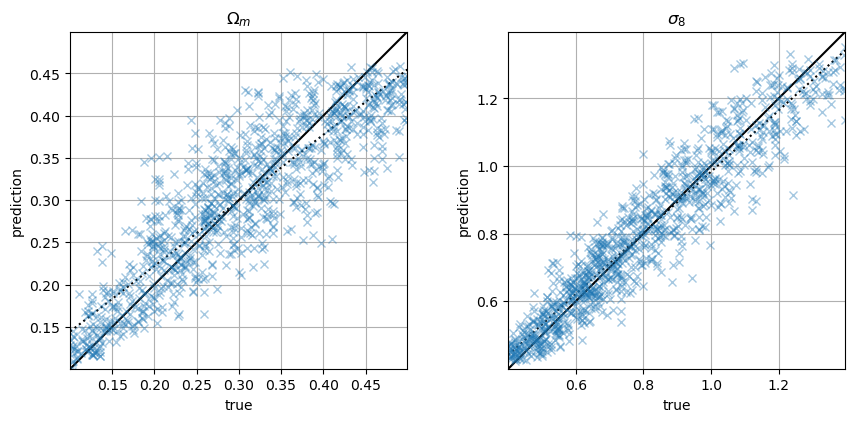

In [234]:
plot_y = label_ids
predictions_best = np.nanmean(preds, axis=0)
predictions_std = np.nanstd(preds, axis=0)

upp_lims = np.nanmax(plot_y, axis=0)
low_lims = np.nanmin(plot_y, axis=0)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.subplots_adjust(wspace=0.3, hspace=0.2)
labels = [r"$\Omega_m$", r"$\sigma_8$"]
for ind, (label, ax, low_lim, upp_lim) in enumerate(zip(labels, axs.ravel(), low_lims, upp_lims)):
    p = np.poly1d(np.polyfit(plot_y[:, ind], predictions_best[:, ind], 1))
    # ax.errorbar(plot_y[:, ind][::10], predictions_best[:, ind][::10],  predictions_std[:, ind][::10], marker="x", ls='none', alpha=0.4)
    ax.errorbar(plot_y[:, ind][::10], predictions_best[:, ind][::10],  0, marker="x", ls='none', alpha=0.4)
    ax.set_xlabel("true")
    ax.set_ylabel("prediction")
    ax.plot([low_lim, upp_lim], [low_lim, upp_lim], color="black")
    ax.plot([low_lim, upp_lim], [p(low_lim), p(upp_lim)], color="black", ls=":")
    ax.set_xlim([low_lim, upp_lim])
    ax.set_ylim([low_lim, upp_lim])
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(label)
    ax.grid()
plt.show()
plt.close()

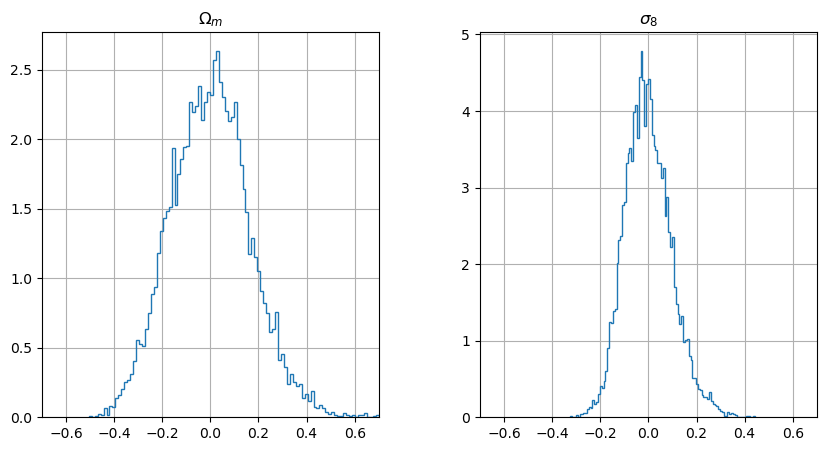

In [241]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.subplots_adjust(wspace=0.3, hspace=0.2)
labels = [r"$\Omega_m$", r"$\sigma_8$"]
for ind, (label, ax) in enumerate(zip(labels, axs.ravel())):
    ax.hist((plot_y[:, ind] - predictions_best[:, ind]) / predictions_best[:, ind], bins=100, density=True, histtype="step")
    ax.set_title(label)
    ax.grid()
    ax.set_xlim([-0.7, 0.7])
plt.show()
plt.close()

In [242]:
indexes = np.random.randint(len(data["validation"]), size=5)
indexes

array([5056, 8110, 3840, 1028, 7385])

0


[0.18261719 0.88779294]
[0.19288777 0.8274028 ] [0.19290996 0.8269844 ]


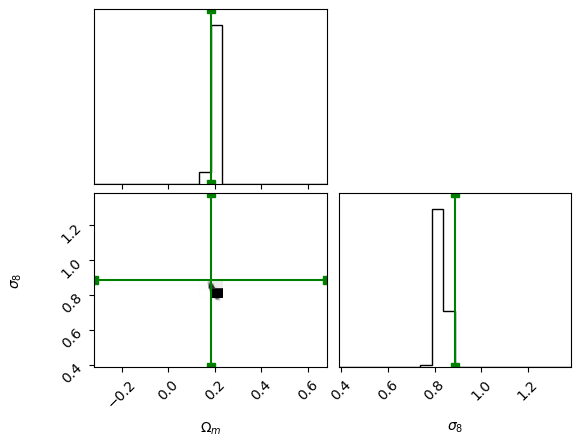

1


[0.4408203 0.5977539]
[0.44817206 0.5844794 ] [0.44788557 0.58433104]


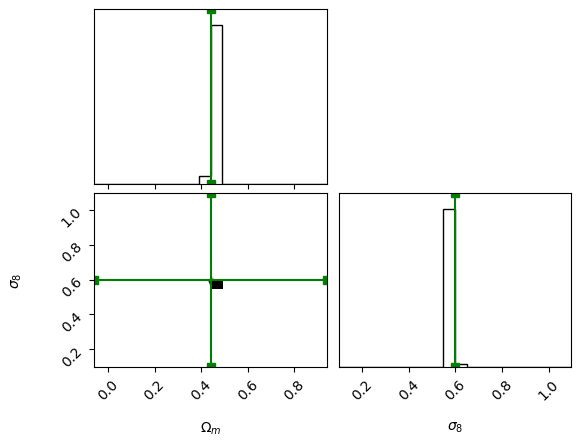

2


[0.3953125 0.8179687]
[0.34219727 0.9103179 ] [0.34241438 0.91006184]


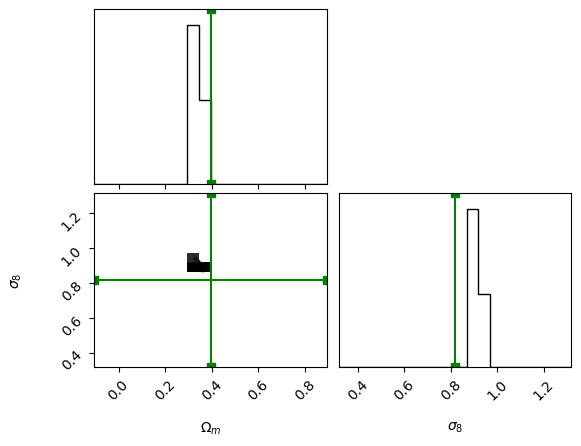

3


[0.37441406 0.46689454]
[0.3675401  0.48678505] [0.36762998 0.48616582]


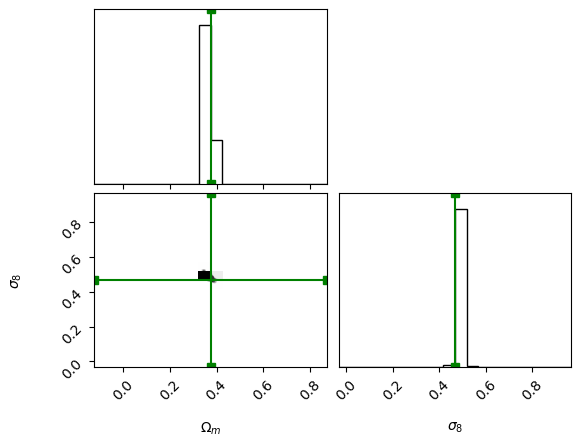

4


[0.17050782 1.1329101 ]
[0.17989701 1.1389744 ] [0.17994894 1.1390758 ]


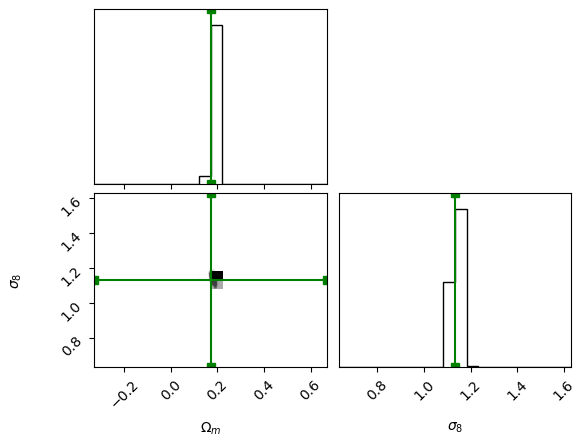

In [243]:
import corner

n_pred = 1001

for ind in range(5):
    print(ind)
    index = indexes[ind]
    data_repeat = {}
    for key, val in data["validation"][index:index+1].items():
        if key == "labels":
            data_repeat[key] = np.repeat(val, n_pred, axis=0)
            continue
        data_repeat[key] = val * n_pred    
    datapoint = Dataset.from_dict(data_repeat)
    datapoint.set_transform(preprocess_val)
    preds_one = trainer.predict(datapoint).predictions
    
    labels = lab_x, lab_y = data["validation"][index:index+1]["labels"][0]
    margin = 5e-1
    print(labels)
    print(np.nanmean(preds_one, axis=0), np.nanmedian(preds_one, axis=0))
    fig = plt.figure()
    corner.corner(preds_one, fig=fig, labels=[r"$\Omega_m$", r"$\sigma_8$"], \
                  range=[(lab_x-margin, lab_x+margin), (lab_y-margin, lab_y+margin)])
    corner.overplot_lines(fig, labels, marker="s", color="green")
    plt.show()
    plt.close()